In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nba-mvp-voting-stats/data_mvp.csv
/kaggle/input/nba-mvp-voting-stats/test_data_mvp.csv


In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

In [3]:
main_data=pd.read_csv("/kaggle/input/nba-mvp-voting-stats/data_mvp.csv")
test_data=pd.read_csv("/kaggle/input/nba-mvp-voting-stats/test_data_mvp.csv")

In [4]:
features=[ 'per','ts_pct', 'usg_pct', 'bpm', 'pts_per_g', 'trb_per_g', 'ast_per_g',
       'stl_per_g', 'blk_per_g', 'ws', 'win_pct']

X=main_data[features].copy()
y = main_data[['award_share']].to_numpy()
y = y.reshape(y.shape[0], )

y=pd.Series(y)

In [5]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,random_state=21)

benchmark_model=XGBRegressor(random_state=21)

benchmark_model.fit(X_train,y_train)
pred=benchmark_model.predict(X_valid)
        

mean=mean_absolute_error(y_valid,pred)

print(mean)

0.09641556040055911


In [6]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(0,500,50),
    'max_depth': range(3,7),
    'learning_rate': [0.05,0.1,0.15,0.2,0.25],
    'subsample':[0.8,0.9,1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_jobs':[4]
}

# Instantiate the regressor: gbm
gbm = XGBRegressor(random_state=21)

#Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "neg_mean_absolute_error", 
                                    verbose = 1, n_iter = 50, cv = 6,n_jobs=4)


#Fit randomized_mse to the data
xgb_random.fit(X, y)

#Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best neg_mean_absolute_error found: ", xgb_random.best_score_*-1)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min


Best parameters found:  {'subsample': 0.8, 'n_jobs': 4, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best neg_mean_absolute_error found:  0.10545785762801192


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.7min finished


In [7]:
from lightgbm import LGBMRegressor as lgb

lgb_param_grid = {
    'n_estimators': range(0,500,50),
    'max_depth': range(3,7),
    'learning_rate': [0.05,0.1,0.15,0.2,0.25],
    'subsample':[0.8,0.9,1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_jobs':[4]
}

lgb_model = lgb(random_state=21)

lgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                   estimator = lgb_model, scoring = "neg_mean_absolute_error", 
                                  verbose = 1, n_iter = 10, cv = 6,n_jobs=4)

lgb_random.fit(X, y)

print("Best parameters found: ", lgb_random.best_params_)
print("Best neg_mean_absolute_error found: ", lgb_random.best_score_*-1)


Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   27.2s finished


Best parameters found:  {'subsample': 0.8, 'n_jobs': 4, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.7}
Best neg_mean_absolute_error found:  0.10594098203863633


In [8]:
X_test=test_data[features].copy()
benchmark_model=XGBRegressor(n_estimators=150,max_depth= 3,subsample=0.9,colsample_bytree=0.8,
                   learning_rate=0.05,n_jobs=4,random_state=21)
benchmark_model.fit(X,y)
benchmark_rank=benchmark_model.predict(X_test)
benchmark_rank


array([ 0.6047746 ,  0.46202928,  0.4394877 ,  0.29266328,  0.24929044,
        0.25361758,  0.11955807, -0.00160223, -0.00257236,  0.05012992],
      dtype=float32)

In [9]:
names=test_data["player"].copy()
names=names.to_numpy()
Prediction_Basketball_Reference=test_data["value"].copy()
Prediction_Basketball_Reference=Prediction_Basketball_Reference.to_numpy()

In [10]:
results= list(zip(names,Prediction_Basketball_Reference,benchmark_rank))
result_df=pd.DataFrame(results,columns=["Name","Prediction_Basketball_Reference","XGB_Benchmark_Prediction"])
result_df["XGB_Benchmark_Prediction"]=result_df["XGB_Benchmark_Prediction"]*100
result_df

,Name,Prediction_Basketball_Reference,XGB_Benchmark_Prediction
0,Giannis Antetokounmpo,50.7%,60.477459
1,LeBron James,17.3%,46.202928
2,James Harden,10.5%,43.948770
3,Anthony Davis,9.8%,29.266328
4,Luka Dončić,4.0%,24.929044
5,Kawhi Leonard,2.1%,25.361758
6,Nikola Jokić,1.8%,11.955807
7,Khris Middleton,1.5%,-0.160223
8,Kyle Lowry,1.1%,-0.257236
9,Jimmy Butler,1.1%,5.012992


In [11]:
sum=result_df["XGB_Benchmark_Prediction"].sum()
XGB_Benchmark_Prediction=result_df["XGB_Benchmark_Prediction"].copy().to_numpy()


for index,award_share in enumerate(XGB_Benchmark_Prediction):
    result_df.iloc[index,2]=(award_share/sum)*100

result_df

,Name,Prediction_Basketball_Reference,XGB_Benchmark_Prediction
0,Giannis Antetokounmpo,50.7%,24.510838
1,LeBron James,17.3%,18.725530
2,James Harden,10.5%,17.811945
3,Anthony Davis,9.8%,11.861315
4,Luka Dončić,4.0%,10.103463
5,Kawhi Leonard,2.1%,10.278837
6,Nikola Jokić,1.8%,4.845555
7,Khris Middleton,1.5%,-0.064937
8,Kyle Lowry,1.1%,-0.104255
9,Jimmy Butler,1.1%,2.031710


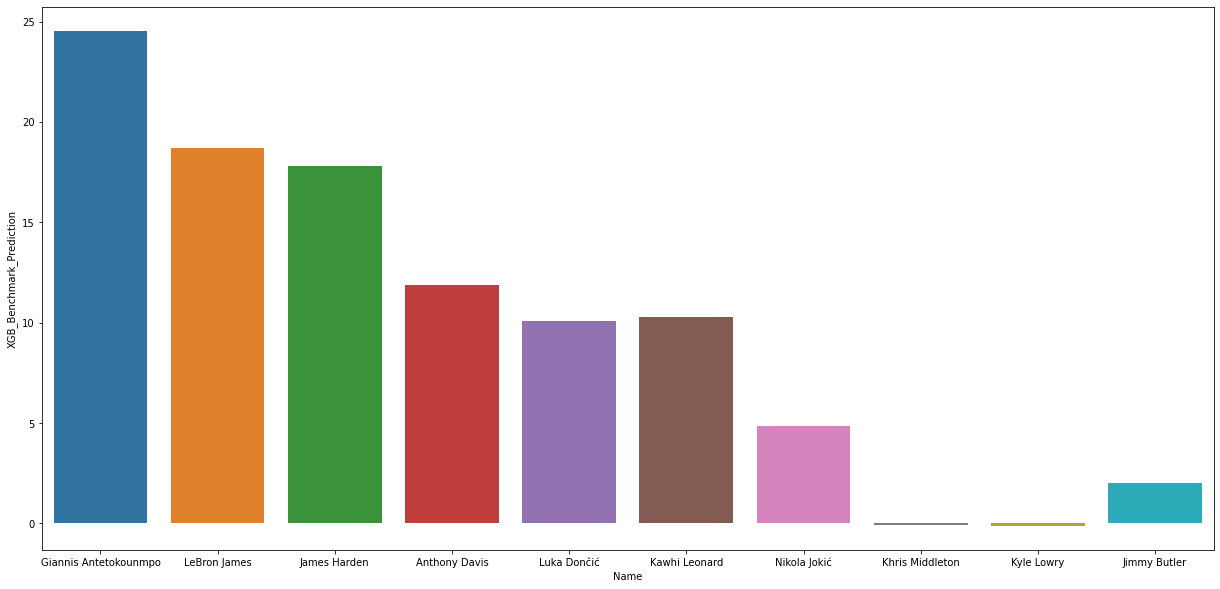

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(21,10))
sns.barplot(x="Name",y="XGB_Benchmark_Prediction",data=result_df)
plt.show()

In [13]:
benchmark_model=lgb( subsample=0.8, n_jobs=4, n_estimators=200, max_depth=3,
                    learning_rate = 0.15, colsample_bytree= 0.7)

In [14]:
benchmark_model.fit(X,y)
benchmark_rank=benchmark_model.predict(X_test)
benchmark_rank

array([ 0.61598543,  0.54639537,  0.34591065,  0.2679519 ,  0.21203788,
        0.10655819,  0.08208306, -0.02692715, -0.00183936, -0.00180876])

In [15]:
result_df["LGBM_Benchmark_Prediction"]=benchmark_rank*100

sum=result_df["LGBM_Benchmark_Prediction"].sum()
LGBM_Benchmark_Prediction=result_df["LGBM_Benchmark_Prediction"].copy().to_numpy()


for index,award_share in enumerate(LGBM_Benchmark_Prediction):
    result_df.iloc[index,3]=(award_share/sum)*100

result_df

,Name,Prediction_Basketball_Reference,XGB_Benchmark_Prediction,LGBM_Benchmark_Prediction
0,Giannis Antetokounmpo,50.7%,24.510838,28.699244
1,LeBron James,17.3%,18.725530,25.456989
2,James Harden,10.5%,17.811945,16.116249
3,Anthony Davis,9.8%,11.861315,12.484089
4,Luka Dončić,4.0%,10.103463,9.879011
5,Kawhi Leonard,2.1%,10.278837,4.964630
6,Nikola Jokić,1.8%,4.845555,3.824314
7,Khris Middleton,1.5%,-0.064937,-1.254557
8,Kyle Lowry,1.1%,-0.104255,-0.085697
9,Jimmy Butler,1.1%,2.031710,-0.084271


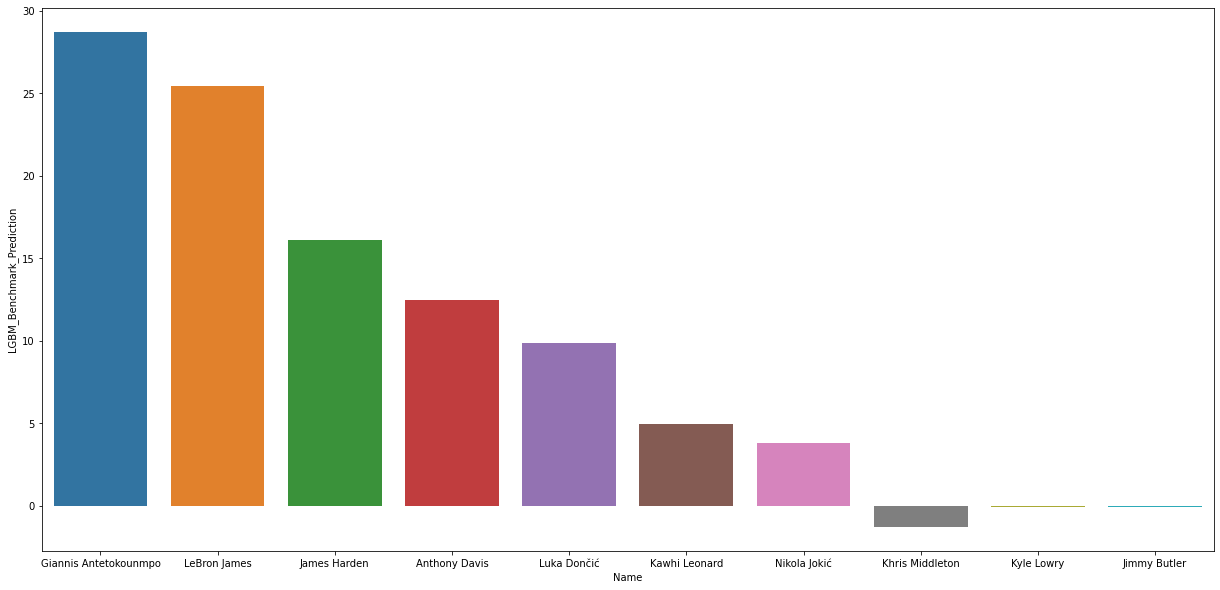

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(21,10))
sns.barplot(x="Name",y="LGBM_Benchmark_Prediction",data=result_df)
plt.show()

In [17]:
result_df_rearranged=result_df.drop('Prediction_Basketball_Reference',axis=1)
result_df_rearranged = pd.melt(result_df_rearranged, id_vars="Name", var_name="regressors", value_name="win prediction")
result_df_rearranged

,Name,regressors,win prediction
0,Giannis Antetokounmpo,XGB_Benchmark_Prediction,24.510838
1,LeBron James,XGB_Benchmark_Prediction,18.725530
2,James Harden,XGB_Benchmark_Prediction,17.811945
3,Anthony Davis,XGB_Benchmark_Prediction,11.861315
4,Luka Dončić,XGB_Benchmark_Prediction,10.103463
5,Kawhi Leonard,XGB_Benchmark_Prediction,10.278837
6,Nikola Jokić,XGB_Benchmark_Prediction,4.845555
7,Khris Middleton,XGB_Benchmark_Prediction,-0.064937
8,Kyle Lowry,XGB_Benchmark_Prediction,-0.104255
9,Jimmy Butler,XGB_Benchmark_Prediction,2.031710


<Figure size 1512x720 with 0 Axes>

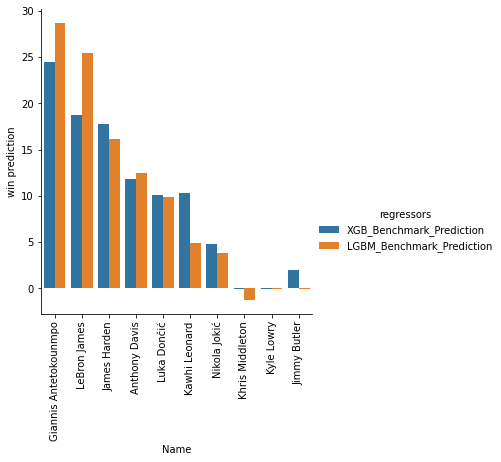

In [18]:
plt.figure(figsize=(21,10))
plot=sns.catplot(x='Name', y='win prediction', hue='regressors', data=result_df_rearranged,
                 kind='bar')
plot.set_xticklabels(rotation=90)